In [1]:
import sys
import time
print(sys.executable)
from utils import *

/Users/clivian/opt/anaconda3/bin/python


In [2]:
# daily_ratings, movie_ratings = loadDic()
daily_ratings, movie_ratings = loadDic()

In [3]:
# mostPop(daily_ratings, 62423, sys.maxsize)

In [4]:
temp_mkeys = mostPop(daily_ratings, 20, (2019, 1, 1))
temp_mtitles = getMovieTitleById(temp_mkeys)

['Star Wars: Episode IV - A New Hope (1977)', 'Pulp Fiction (1994)', 'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)', "Schindler's List (1993)", 'Silence of the Lambs, The (1991)', 'Godfather, The (1972)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'Matrix, The (1999)', 'American Beauty (1999)', 'Fight Club (1999)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Lord of the Rings: The Two Towers, The (2002)', 'Lord of the Rings: The Return of the King, The (2003)', 'Dark Knight, The (2008)', 'WALL·E (2008)', 'Up (2009)', 'Avatar (2009)', 'Inception (2010)']


In [5]:
temp_mkeys
time_dic = {
    2015:[(2014, 11), (2014, 12)] + ([(2015, m) for m in range(1, 11)]),
    2016:[(2015, 11), (2015, 12)] + ([(2016, m) for m in range(1, 11)]),
    2017:[(2016, 11), (2016, 12)] + ([(2017, m) for m in range(1, 11)]),
    2018:[(2017, 11), (2017, 12)] + ([(2018, m) for m in range(1, 11)]),
    2019:[(2018, 11), (2018, 12)] + ([(2019, m) for m in range(1, 11)])
}

In [6]:
def getRPrecision(params):
    delta_t_list = params['delta_t']
    day_aves = []
    for delta_t in delta_t_list:
        day_ave = {}
        for _year in range(2015, 2020):
            day_count = 0
            for year, month in time_dic[_year]:
                for day in range(1, 32):
                    date = (year, month, day)
                    if daily_ratings.get(date, -1) == -1:
                        print('date', date, 'invalid')
                        continue
                    day_count += 1
                    user_activities = getUserActivities(daily_ratings[date])
                    max_R = getMaxR(user_activities)
                    day_recentPop = day_decayPop = delta_t
                    
                    max_R_mostPop, max_R_recentPop, max_R_decayPop = (
                        mostPop(daily_ratings, max_R, date),
                        recentPop(daily_ratings, max_R, date, day_recentPop),
                        decayPop(daily_ratings, max_R, date, day_decayPop)
                    )

                    mostPop_cur, recentPop_cur, decayPop_cur = (
                        RPrecision(user_activities, max_R_mostPop),
                        RPrecision(user_activities, max_R_recentPop),
                        RPrecision(user_activities, max_R_decayPop)
                    )
                    
                    day_ave[date] = [mostPop_cur, recentPop_cur, decayPop_cur]
        day_aves.append(day_ave)
    return day_aves

In [11]:
start = time.time() 
params = {}
# params['delta_t'] = [1, 2]
params['delta_t'] = [1, 2, 4, 8, 16, 32]
day_aves = getRPrecision(params)
np.save(os.path.join('data', 'day_aves.npy'), day_aves)
end = time.time()
elapse = end - start
print(elapse)

date (2014, 11, 31) invalid


KeyboardInterrupt: 

In [14]:
day_aves = np.load(os.path.join('data', 'day_aves.npy'), allow_pickle=True).tolist()
print(day_aves)
month_aves = []
year_aves = []
weekday_pattern = []
for method in range(0, 3):
    year_ave_per_method = []
    month_ave_per_method = []
    weekday_pattern_per_method = [[] for i in range(7)]
    for day_ave in day_aves:
        year_ave_per_param = []
        month_ave_per_param = []
        for _year in range(2015, 2020):
            year_value = []
            for year, month in time_dic[_year]:
                month_value = []
                for day in range(1, 32):
                    value = day_ave.get((year, month, day), -1)
                    if value != -1:
                        month_value.append(value[method])
                        year_value.append(value[method])
                        if day_ave == day_aves[2]: # deltat = 4
                            weekday = date(year, month, day).weekday()
                            weekday_pattern_per_method[weekday].append(value[method])
                month_ave_per_param.append(sum(month_value) / len(month_value) * 100)
            year_ave_per_param.append("%.3f" % (sum(year_value) / len(year_value) * 100))
        year_ave_per_method.append(year_ave_per_param)
        month_ave_per_method.append(month_ave_per_param)
    year_aves.append(year_ave_per_method)
    month_aves.append(month_ave_per_method)
    weekday_pattern.append([(sum(v) / len(v) * 100) for v in weekday_pattern_per_method])

[{(2014, 11, 1): [0.008540935832209513, 0.0056083400607877375, 0.0056083400607877375], (2014, 11, 2): [0.014890439173054448, 0.02361615279120698, 0.02361615279120698], (2014, 11, 3): [0.021399130513531737, 0.018799382557806502, 0.018799382557806502], (2014, 11, 4): [0.016167973956457093, 0.013353208133232302, 0.013353208133232302], (2014, 11, 5): [0.03838074716934085, 0.023287167023171167, 0.023287167023171167], (2014, 11, 6): [0.06502915072794033, 0.06515033990142356, 0.06515033990142356], (2014, 11, 7): [0.056739669917635044, 0.06392373783644009, 0.06392373783644009], (2014, 11, 8): [0.06100116062434322, 0.06253680553984328, 0.06253680553984328], (2014, 11, 9): [0.045560285728246386, 0.043663556175114346, 0.043663556175114346], (2014, 11, 10): [0.038332654446657254, 0.043936134714765165, 0.043936134714765165], (2014, 11, 11): [0.04755092639171528, 0.06296997406945003, 0.06296997406945003], (2014, 11, 12): [0.03387987355203699, 0.10248364446417405, 0.10248364446417405], (2014, 11, 13)

<ipython-input-15-cf6f2c38f95e>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(year_x)


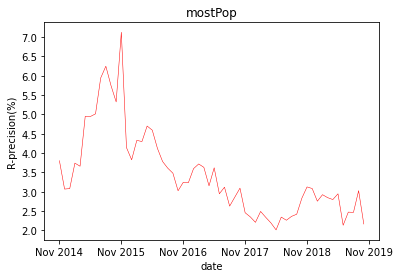

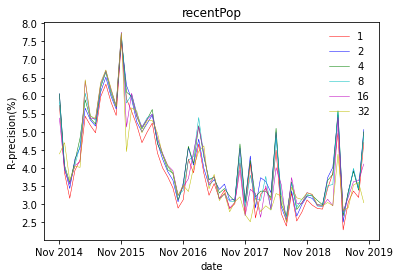

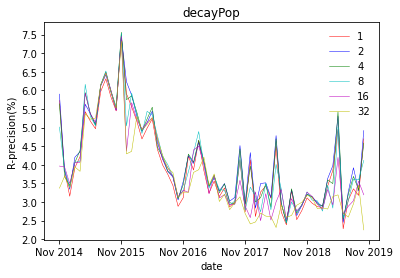

In [15]:
# plot monthly average
year_x = []
for year in range(2013, 2020):
    year_x.append('Nov ' + str(year))
year_x[0] = 'Nov 2014'
temp_x = [i for i in range(0, 60)]
methods = ['mostPop', 'recentPop', 'decayPop']
colors = ['r', 'b', 'g', 'c', 'm', 'y']
for i in range(0, len(methods)):
    fig, ax = plt.subplots()
    import matplotlib.ticker as plticker
    x_loc = plticker.MultipleLocator(base=12)
    y_loc = plticker.MultipleLocator(base=0.5)
    ax.xaxis.set_major_locator(x_loc)
    ax.yaxis.set_major_locator(y_loc)
    ax.set_title(str(methods[i]), loc='center')
    if methods[i] == 'mostPop':
        param = params['delta_t'][0]
        ax.plot(temp_x, month_aves[i][0], color=colors[0], linewidth=0.5)
    else:
        for j in range(0, len(params['delta_t'])):
            param = params['delta_t'][j]
            ax.plot(temp_x, month_aves[i][j], color=colors[j], linewidth=0.5, label=str(param))
        ax.legend(loc='upper right', frameon=False)
    ax.set_xticklabels(year_x)
    ax.set_xlabel('date')
    ax.set_ylabel('R-precision(%)' )
    fig.savefig('./figures/monthly_average_' + str(methods[i]), bbox_inches='tight', dpi=300)

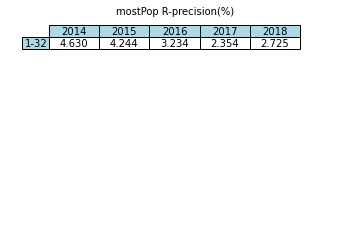

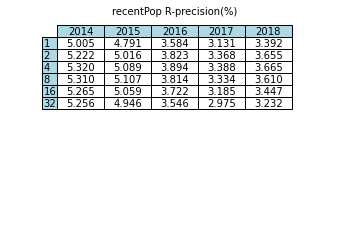

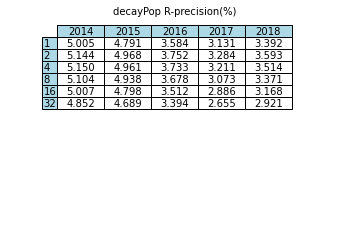

In [16]:
# plot yearly average
for i in range(0, len(methods)):
    fig, ax = plt.subplots() 
    ax.set_axis_off() 
    ax.set_title(str(methods[i]) + ' R-precision(%)', loc='center', fontsize=10)
    if methods[i] == 'mostPop':        
        table = ax.table(
            cellText = [year_aves[i][0]],
            colLabels = [year for year in range(2014, 2020)],
            rowLabels = ['1-32'],
            rowColours = ["lightblue"] * 1,  
            colColours = ["lightblue"] * len(year_aves[i][0]), 
            colWidths = [0.15] * len(year_aves[i][0]),
            cellLoc = 'center',
            loc = 'upper center',
        )
    else:
        table = ax.table(
            cellText = year_aves[i],
            rowLabels = params['delta_t'],
            colLabels = [year for year in range(2014, 2019)],
            rowColours = ["lightblue"] * len(year_aves[i]),  
            colColours = ["lightblue"] * len(year_aves[i][0]), 
            colWidths= [0.14] * len(year_aves[i][0]),
            cellLoc ='center',
            loc ='upper center',
        )
    bbox = table.get_window_extent(fig.canvas.get_renderer())
    bbox = bbox.from_extents(bbox.xmin-5, bbox.ymin-5, bbox.xmax+5, bbox.ymax+25)
    bbox_inches = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('./figures/yearly_average_' + str(methods[i]), bbox_inches=bbox_inches, dpi=300)
    

<ipython-input-17-fba989157808>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])


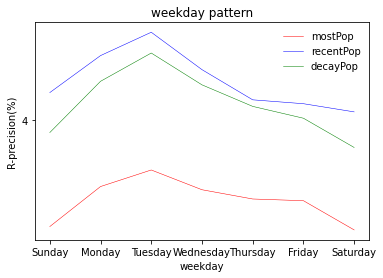

In [17]:
# weekday_pattern
fig, ax = plt.subplots()
temp_x = [i for i in range(7)]
x_loc = plticker.MultipleLocator(base=1)
y_loc = plticker.MultipleLocator(base=2)
ax.xaxis.set_major_locator(x_loc)
ax.yaxis.set_major_locator(y_loc)
ax.set_title('weekday pattern', loc='center')
for i in range(3):
    ax.plot(temp_x,
            weekday_pattern[i],
            color=colors[i], linewidth=0.5, label = methods[i])
ax.set_xticklabels(['', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
ax.legend(loc='upper right', frameon=False)
ax.set_xlabel('weekday')
ax.set_ylabel('R-precision(%)' )
fig.savefig('./figures/weekday_pattern', bbox_inches='tight', dpi=300)